<a href="https://colab.research.google.com/github/AbdelRayan/ThetaGammaAnalysis/blob/main/notebooks/Tutorial_2_Cycle_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install emd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.4 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import emd.sift as sift
import emd.spectra as spectra
import scipy.io as sio


In [ ]:
# Scientific to Float Print Format
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.7f}'.format})

In [ ]:
# Tutorial 1 Summary and pre-loading variables

## Loading data
lfp=np.squeeze(sio.loadmat(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/HPC_100_CH42_0.continuous.mat')['HPC'])
states=np.squeeze(sio.loadmat(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/2022-02-08_14-47-29_posttrial5-states_TS.mat')['states'])

In [ ]:
# Remove this in the main pipeline folder

def get_rem_states(states, sample_rate):
    """
    Extract consecutive REM (Rapid Eye Movement) sleep states from a binary sleep state vector.

    Parameters:
    states (numpy.ndarray): A sleep state vector where 5 represents REM sleep and other values indicate non-REM.
    sample_rate (int or float): The sampling rate of the data.

    Returns:
    numpy.ndarray: An array of consecutive REM sleep state intervals in seconds, represented as (start, end) pairs.

    Notes:
    - This function processes a binary sleep state vector and identifies consecutive REM sleep intervals.
    - It calculates the start and end times of each REM state interval based on the provided sample rate.
    - The resulting intervals are returned as a numpy array of (start, end) pairs in seconds.
    """
    states = np.squeeze(states)
    rem_state_indices = np.where(states == 5)[0]
    rem_state_changes = np.diff(rem_state_indices)
    split_indices = np.where(rem_state_changes != 1)[0] + 1
    split_indices = np.concatenate(([0], split_indices, [len(rem_state_indices)]))
    consecutive_rem_states = np.empty((len(split_indices) - 1, 2))
    for i, (start, end) in enumerate(zip(split_indices, split_indices[1:])):
        start = rem_state_indices[start] * int(sample_rate)
        end = rem_state_indices[end - 1] * int(sample_rate)
        consecutive_rem_states[i] = np.array([start, end])
    consecutive_rem_states = np.array(consecutive_rem_states)
    null_states_mask = np.squeeze(np.diff(consecutive_rem_states) > 0)
    consecutive_rem_states = consecutive_rem_states[null_states_mask]
    return consecutive_rem_states

    # Defining the theta gamma split function

def tg_split(mask_freq, theta_range=(5, 12)):
    """
        Split a frequency vector into sub-theta, theta, and supra-theta components.

        Parameters:
        mask_freq (numpy.ndarray): A frequency vector or array of frequency values.
        theta_range (tuple, optional): A tuple defining the theta frequency range (lower, upper).
            Default is (5, 12).

        Returns:
        tuple: A tuple containing boolean masks for sub-theta, theta, and supra-theta frequency components.

        Notes: - This function splits a frequency mask into three components based on a specified theta frequency
        range. - The theta frequency range is defined by the 'theta_range' parameter. - The resulting masks 'sub',
        'theta', and 'supra' represent sub-theta, theta, and supra-theta frequency components.
    """
    lower = np.min(theta_range)
    upper = np.max(theta_range)
    mask_index = np.logical_and(mask_freq >= lower, mask_freq < upper)
    sub_mask_index = mask_freq < lower
    supra_mask_index = mask_freq > upper
    sub = sub_mask_index
    theta = mask_index
    supra = supra_mask_index

    return sub, theta, supra

In [ ]:
# Load the REM states
s_rate= 2500
rem_states=get_rem_states(states, s_rate).astype(int)
first_rem=lfp[rem_states[0,0]:rem_states[0,1]] # Load the first REM epoch for our example

# Generate the IMFs
imask=emd.sift.iterated_mask_sift(first_rem,mask_0='zc',sample_rate=s_rate,ret_mask_freq='True')

# Extract the theta signal
_, theta, _ = tg_split(imask[1])
theta_sig=np.sum(imask[0].T[theta],axis=0)

# Definition of a Cycle

Traditionally a cycle is defined as zero-crossing, peak (trough), zero-crossing, trough (peak), zero-crossing. This definition can be shifted to be represented as trough, zero-crossing, peak, zero-crossing, trough. In this manner we can investigate the signal properties of theta peaks and their nested gamma activity.

# Extrema Detection

In order to parse a cycle effetively, certain parts need to be identified on the signal effectively. Once all these parts (extrema) are gathered, cycles can be constructed by their given type of extrema and indices.

In [ ]:
#@title ## Zero Crossing Detection

#@markdown The zero crossing detection is done mainly thorugh this line of code in our `zero_cross` function, a technique refactored from the `bycycle` python library.

#@markdown ```decay = np.logical_and((x > 0)[1:], ~(x > 0)[:-1]).nonzero()[0]```

#@markdown ```rise = np.logical_and((x <= 0)[1:], ~(x <= 0)[:-1]).nonzero()[0]```



In [ ]:
# Defining Zero-Cross detection function

def zero_cross(x):
    """
    Find the indices of zero-crossings in a 1D signal.

    Parameters:
    x (numpy.ndarray): The input 1D signal.

    Returns:
    numpy.ndarray: An array of indices where zero-crossings occur in the input signal.

    Notes:
    - This function identifies the indices where zero-crossings occur in a given 1D signal.
    - It detects both rising and falling zero-crossings.
    """
    decay = np.logical_and((x > 0)[1:], ~(x > 0)[:-1]).nonzero()[0]
    rise = np.logical_and((x <= 0)[1:], ~(x <= 0)[:-1]).nonzero()[0]
    zero_xs = np.sort(np.append(rise, decay))
    return zero_xs


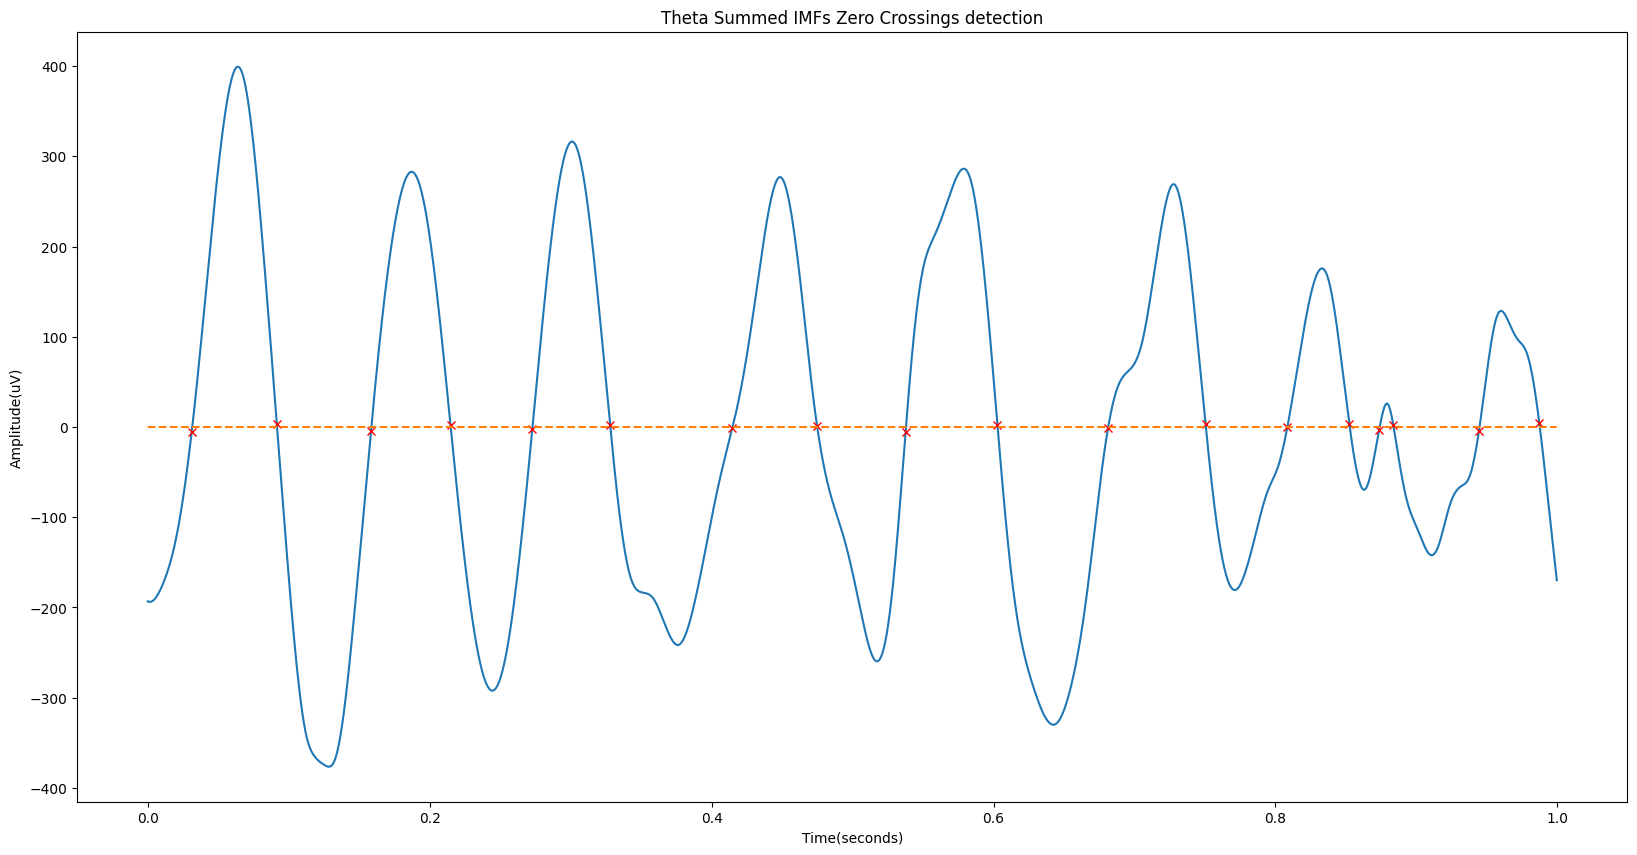

In [ ]:
# Create the time vector
time=len(first_rem)/s_rate
seconds=np.linspace(0,time,len(first_rem))

# Parsing Zero-Cross indices

zero_x= zero_cross(theta_sig)


# Plotting the zero crossing locations

plt.gcf().set_size_inches(20, 10)
plt.plot(seconds[0:2500],theta_sig[:2500])
plt.plot(seconds[zero_x[zero_x <= s_rate]],theta_sig[zero_x[zero_x <= s_rate]], "x",color='red')
plt.plot(seconds[0:2500],np.zeros(2500),'--')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude(uV)')
plt.title('Theta Summed IMFs Zero Crossings detection')
plt.show()

## Trough and Peak Detection

Once the zero crossings are detected, we check each zero-cross pairing for either the maximum or minimum value and classify into sperate arrays of troughs and peaks.



In [ ]:
# Defining the extrema function
def extrema(x):
    """
    Find extrema (peaks, troughs) and zero crossings in a 1D signal.

    Parameters:
    x (numpy.ndarray): The input 1D signal.

    Returns:
    tuple: A tuple containing:
        - numpy.ndarray: Indices of zero-crossings in the input signal.
        - numpy.ndarray: Indices of troughs in the input signal.
        - numpy.ndarray: Indices of peaks in the input signal.

    Notes:
    - This function identifies and returns the indices of zero-crossings, troughs, and peaks in a given 1D signal.
    - Zero-crossings are points where the signal crosses the zero axis.
    - Troughs are local minima, and peaks are local maxima in the signal.
    """
    zero_xs = zero_cross(x)
    peaks = np.empty((0,)).astype(int)
    troughs = np.empty((0,)).astype(int)
    for t1, t2 in zip(zero_xs, zero_xs[1:]):
        extrema0 = np.argmax(np.abs(x[t1:t2])).astype(int) + t1
        if bool(x[extrema0] > 0):
            peaks = np.append(peaks, extrema0)
        else:
            troughs = np.append(troughs, extrema0)
    return zero_xs, troughs, peaks


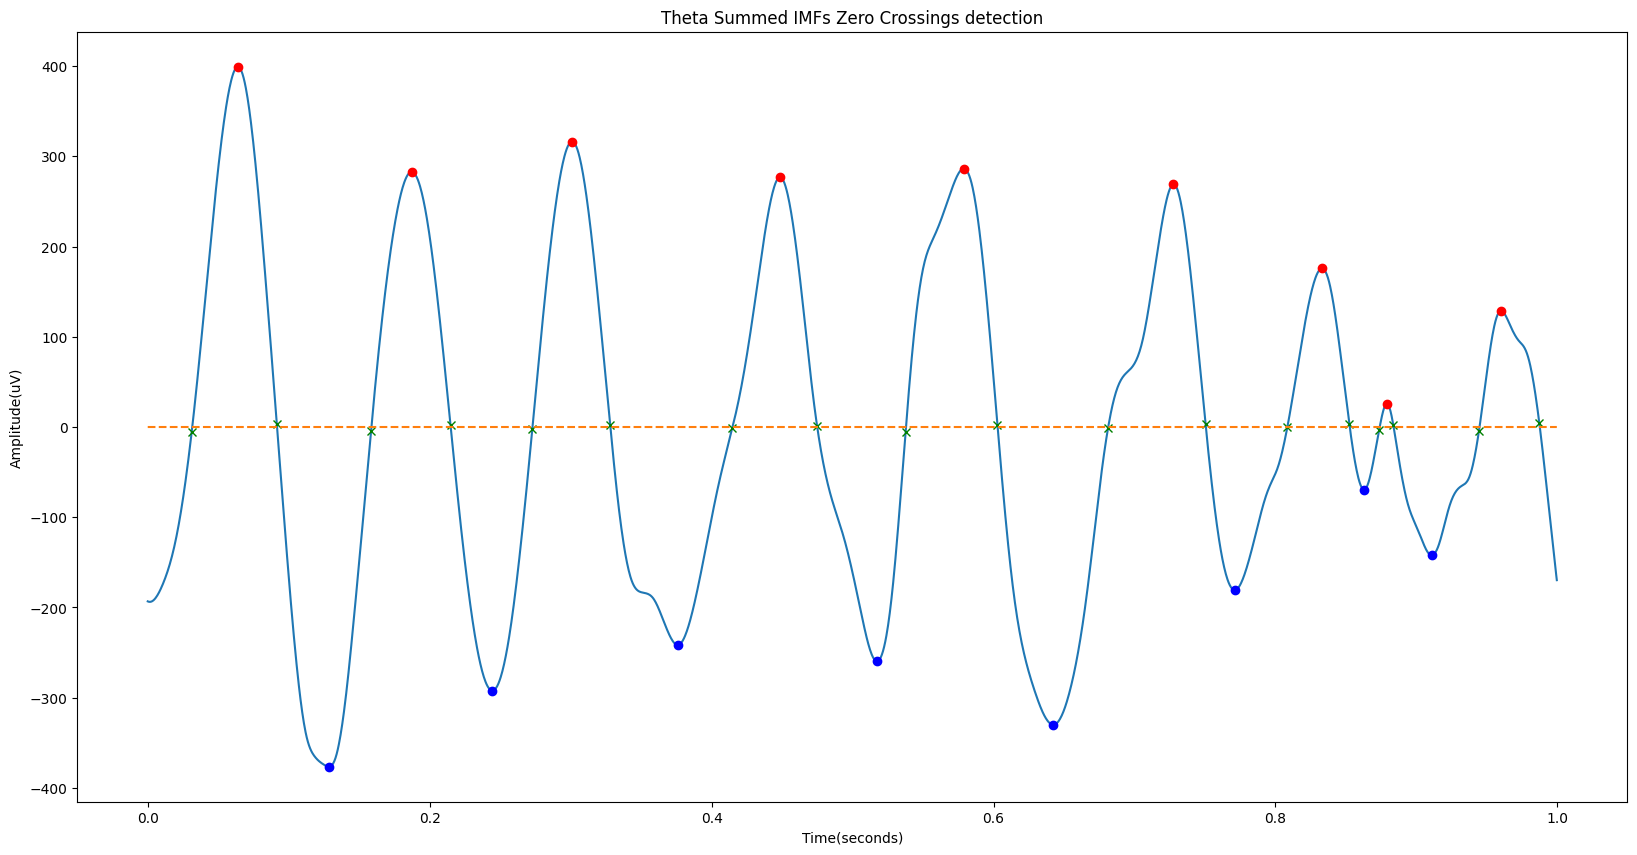

In [ ]:
# Parsing Zero-Crossings , Troughs and Peaks

zero_x, troughs, peaks = extrema(theta_sig)

# Plotting the zero crossing locations

plt.gcf().set_size_inches(20, 10)
plt.plot(seconds[0:2500],theta_sig[:2500])
plt.plot(seconds[zero_x[zero_x <= s_rate]],theta_sig[zero_x[zero_x <= s_rate]], "x",color='green')
plt.plot(seconds[troughs[troughs <= s_rate]],theta_sig[troughs[troughs <= s_rate]], "o",color='blue')
plt.plot(seconds[peaks[peaks <= s_rate]],theta_sig[peaks[peaks <= s_rate]], "o",color='red')
plt.plot(seconds[0:2500],np.zeros(2500),'--')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude(uV)')
plt.title('Theta Summed IMFs Zero Crossings detection')
plt.show()

# Parsing individual cycles

In order to parse a successful cycle, a cycle is traditionally defined as the image below:



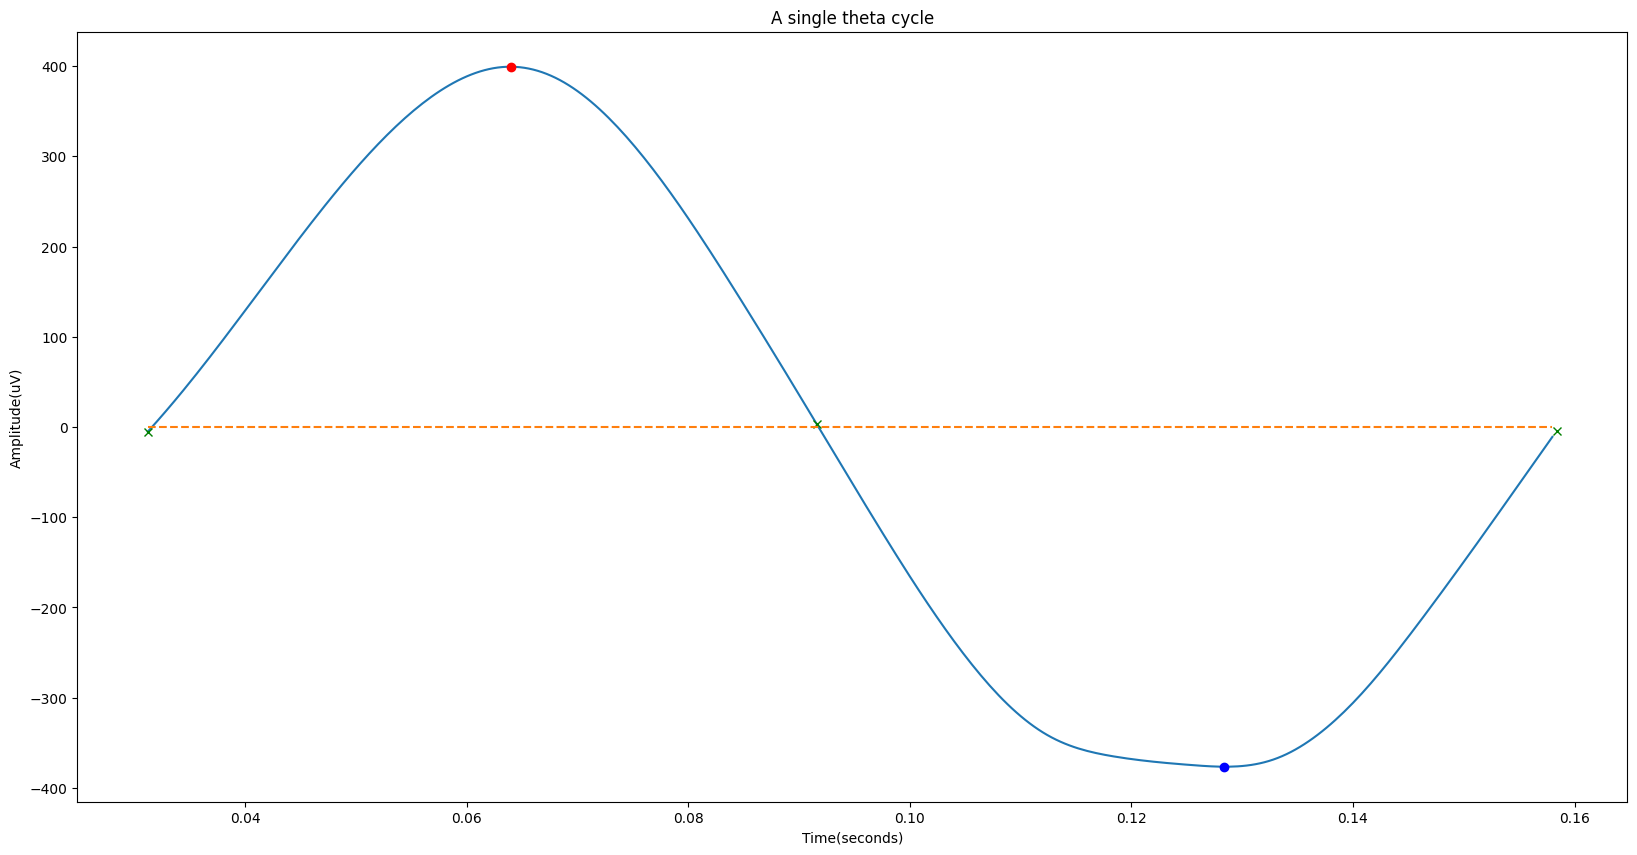

In [ ]:
#@title Parsing an individual cycle

plt.gcf().set_size_inches(20, 10)
plt.plot(seconds[zero_x[0]:zero_x[2]],theta_sig[zero_x[0]:zero_x[2]])
plt.plot(seconds[zero_x[:3]],theta_sig[zero_x[:3]], "x",color='green')
plt.plot(seconds[troughs[0]],theta_sig[troughs[0]], "o",color='blue')
plt.plot(seconds[peaks[0]],theta_sig[peaks[0]], "o",color='red')
plt.plot(seconds[zero_x[0]:zero_x[2]],np.zeros(zero_x[2]-zero_x[0]),'--')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude(uV)')
plt.title('A single theta cycle')
plt.show()


Now that we know how to parse our cycles, we can shift our concentration such that we can observe the behavior of peaks as shown below:

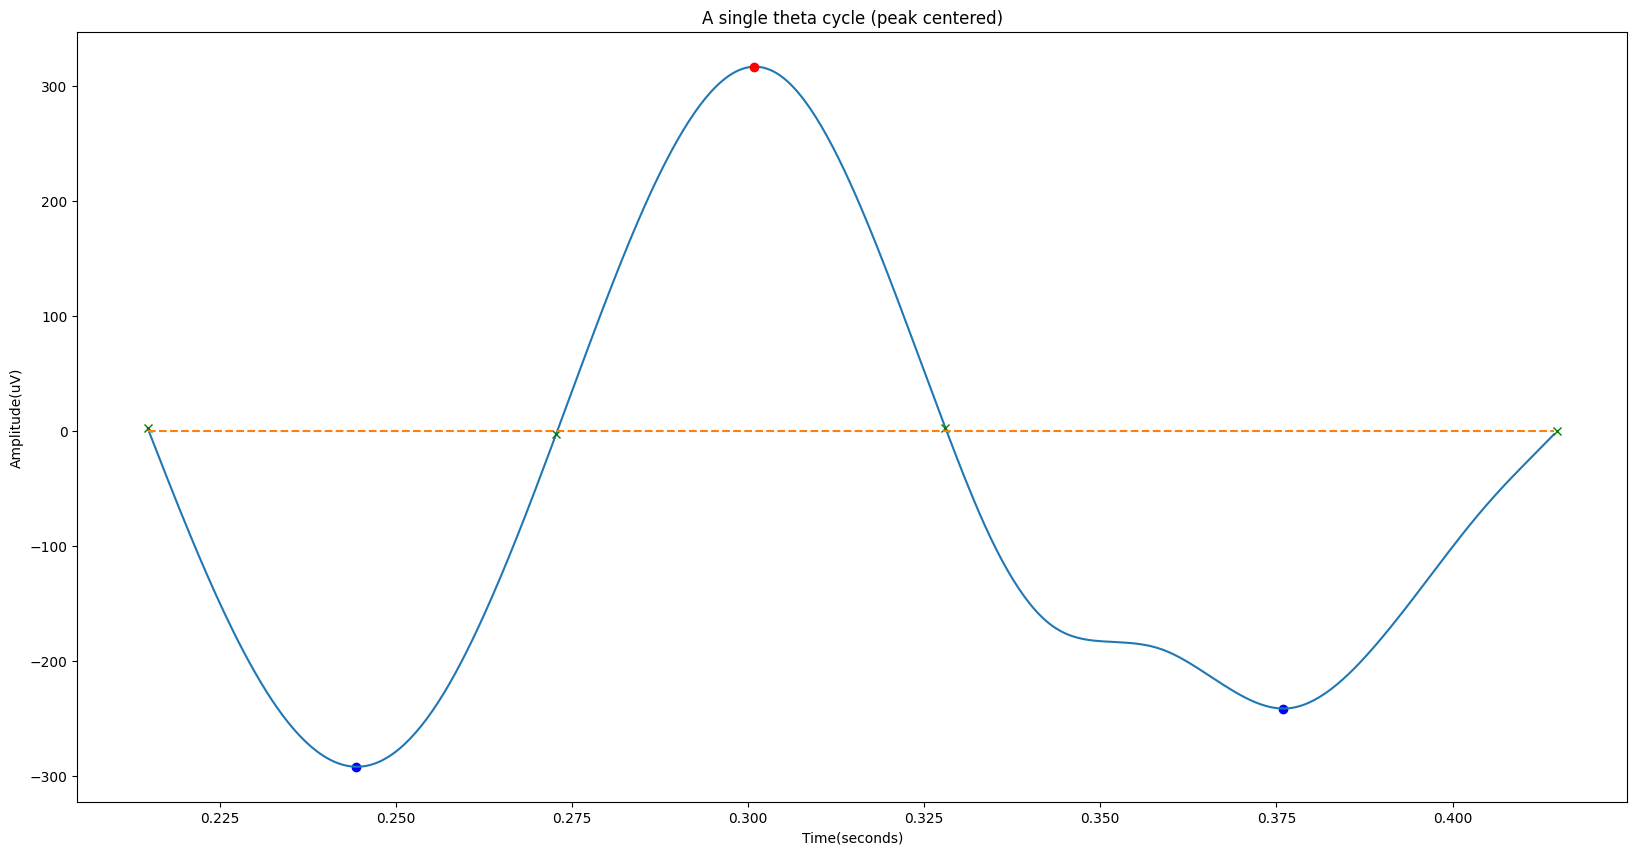

In [ ]:
plt.gcf().set_size_inches(20, 10)
plt.plot(seconds[troughs[1:3]],theta_sig[troughs[1:3]], "o",color='blue')
plt.plot(seconds[zero_x[3]:zero_x[6]],theta_sig[zero_x[3]:zero_x[6]])
plt.plot(seconds[zero_x[3:7]],theta_sig[zero_x[3:7]], "x",color='green')

plt.plot(seconds[peaks[2]],theta_sig[peaks[2]], "o",color='red')
plt.plot(seconds[zero_x[3]:zero_x[6]],np.zeros(zero_x[6]-zero_x[3]),'--')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude(uV)')
plt.title('A single theta cycle (peak centered)')
plt.show()


## Grouping cycles together

The following code segment (taken from [here](https://github.com/AbdelRayan/ThetaGammaAnalysis/blob/main/src/functions.py#L145)) allows us to group the cycles together for all REM epochs of our LFP sleep recordings

In [ ]:
# Initialize variables
x=lfp
rem_states=states
sample_rate = 2500
frequencies= np.arange(20,141,1)
theta_range=(5,12)

In [ ]:
    x = np.squeeze(x)
    rem_states = np.squeeze(rem_states)

    print(x.shape)
    print(rem_states.shape)

    # Detect REM periods
    consecutive_rem_states = get_rem_states(rem_states, sample_rate).astype(int)

    if consecutive_rem_states.ndim == 3:
        consecutive_rem_states=np.squeeze(consecutive_rem_states,0)

    print(consecutive_rem_states.shape)

    # Intiializing variables
    # wt_spectrum = []
    rem_imf = []
    rem_mask_freq = []
    instantaneous_phase = []
    instantaneous_freq = []
    instantaneous_amp = []
    sub_theta_sig = np.empty((0,))
    theta_peak_sig = np.empty((0,))
    cycles = np.empty((0, 5))
    rem_dict = {}
    sub_dict = rem_dict
    good_rem = []
    count = 0
    # Loop through each REM epoch
    for i, rem in enumerate(consecutive_rem_states):
        start = rem[0]
        end = rem[1]+1
        signal = x[start:end]

        # Generate the time-frequency power spectrum
        # print('Generating time-frequency matrix')
        # wavelet_transform = morlet_wt(signal, sample_rate, frequencies, mode='amplitude')

        # Extraction of IMFs and IMF Frequencies for current REM epoch
        print('Finding Intrinsic Mode Functions')
        imf, mask_freq = emd.sift.iterated_mask_sift(signal,
                                                 mask_0='zc',
                                                 sample_rate=sample_rate,
                                                 ret_mask_freq=True)

        # Extract Instantaneous Phase, Frequencies and Amplitudes of each IMF for current REM epoch
        print('Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF')
        IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')

        # wt_spectrum.append(wavelet_transform)
        rem_imf.append(imf)
        rem_mask_freq.append(mask_freq)
        instantaneous_phase.append(IP)
        instantaneous_freq.append(IF)
        instantaneous_amp.append(IA)

        # Identify sub-theta, theta, and supra-theta frequencies
        sub_theta, theta, _ = tg_split(mask_freq, theta_range)

        if np.any(theta):
            print('Theta frequencies are valid')
            count += 1
            good_rem.append(i)
            sub_dict.setdefault(f'REM {count}', {})
        elif not np.any(theta):
            print(f'No valid theta frequencies for REM {i}')
            continue

        print(f'Processing REM {count} ')

        # Generate the theta signal to detect cycles
        theta_sig = np.sum(imf.T[theta], axis=0)

        # Parse the sub-theta signal of all REM periods into one variable to set amplitude threshold
        sub_theta_sig = np.append(sub_theta_sig, np.sum(imf.T[sub_theta], axis=0))

        # Generate extrema locations and zero crossing on the generated theta signal
        zero_x, trough, peak = extrema(np.sum(imf.T[theta], axis=0))
        print(f'Number of zero crossings, {zero_x.shape}')

        # Create the cycles array for the current REM epoch
        zero_x = np.vstack((zero_x[:-2:2], zero_x[1:-1:2], zero_x[2::2])).T

        size_adjust = np.min([trough.shape[0], zero_x.shape[0], peak.shape[0]])
        zero_x = zero_x[:size_adjust]
        cycle = np.empty((size_adjust, 5))
        cycle[:, [0, 2, 4]] = zero_x
        if trough[0] < peak[0]:
            cycle[:, 1] = trough[:zero_x.shape[0]]
            cycle[:, 3] = peak[:zero_x.shape[0]]
        else:
            cycle[:, 3] = trough[:zero_x.shape[0]]
            cycle[:, 1] = peak[:zero_x.shape[0]]

        broken_cycle = cycle[~np.all(np.diff(cycle, axis=1) > 0, axis=1)]
        broken_cycle_mask = np.diff(broken_cycle, axis=1) > 0

        adjust_condition = np.all(np.all(broken_cycle_mask[1:] == [True, False, False, True],
                                         axis=0) == True)
        adjust_loc = np.where(np.all(np.diff(cycle, axis=1) > 0, axis=1) == False)[0][1:-1]

        fixed_cycle = broken_cycle[1:-1]
        if adjust_condition:
            fixed_cycle[:, 1] = cycle[adjust_loc - 1, 1]
            fixed_cycle[:, 3] = cycle[adjust_loc + 1, 3]
        else:
            fixed_cycle[:, 3] = cycle[adjust_loc - 1, 3]
            fixed_cycle[:, 1] = cycle[adjust_loc + 1, 1]

        cycle = cycle[np.all(np.diff(cycle, axis=1) > 0, axis=1)]
        cycle = np.vstack((cycle, fixed_cycle))
        if trough[0] < peak[0]:
            cycle = np.hstack((cycle[:-1, 1:-1], cycle[1:, :2]))
        else:
            cycle = np.hstack((cycle[:-1, 3].reshape((-1, 1)), cycle[1:, :-1]))
        print(f'Number of cycles, {cycle.shape}')
        print('----------------------------------------------------------------------')
        # Create an array of amplitudes at the peaks
        theta_peak_sig = np.append(theta_peak_sig, theta_sig[cycle[:, 2].astype(int)])
        cycles = np.vstack((cycles, cycle + start))

(27009280,)
(10803,)
(8, 2)
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are valid
Processing REM 1 
Number of zero crossings, (751,)
Number of cycles, (374, 5)
----------------------------------------------------------------------
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are valid
Processing REM 2 
Number of zero crossings, (240,)
Number of cycles, (118, 5)
----------------------------------------------------------------------
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are valid
Processing REM 3 
Number of zero crossings, (273,)
Number of cycles, (135, 5)
----------------------------------------------------------------------
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are val

In [ ]:
#@markdown Now that we have extracted the cycles we can determine the number of cycles:

print(f'Number of cycles extracted:{cycles.shape[0]} cycles')

Number of cycles extracted:3602 cycles


## Identification of good theta cycles

In order to identify valid theta cycles, they need to satisfy the frequency conditions (alternatively the duration conditions) and the amplitude thresholds that define theta cycle amplitudes.

### Defining the frequency or duration threshold

Extracting good theta cycles  requires us that each cycles observes `theta_range` (5-12 Hz) Frequency activity, this can also be expressed simply by doing some conversions of the samples into seconds and matched with the frequency defined as **period** We implement this with the following code snippet below.

In [ ]:
upper_diff = np.floor(1000 / np.min(theta_range))
lower_diff = np.floor(1000 / np.max(theta_range))
# A filter mask to omit baad cycles that don't satisfy the cycle duration
diff_mask = np.logical_and(np.diff(cycles[:, [0, -1]], axis=1) * (1000 / sample_rate) > lower_diff,
                           np.diff(cycles[:, [0, -1]], axis=1) * (1000 / sample_rate) <= upper_diff)


### Defining the amplitude threshold

In order to define an amplitude threshold that theta is responsible for the larger amplitudes in our oscillations and should require a minimum boundary limit only. We establish this lower threshold by setting two time the standard deviation of the sum of signals below theta frequencies.

The figure below illustrates the concepts by plotting a distribution of all the amplitudes below theta from all REM epochs.

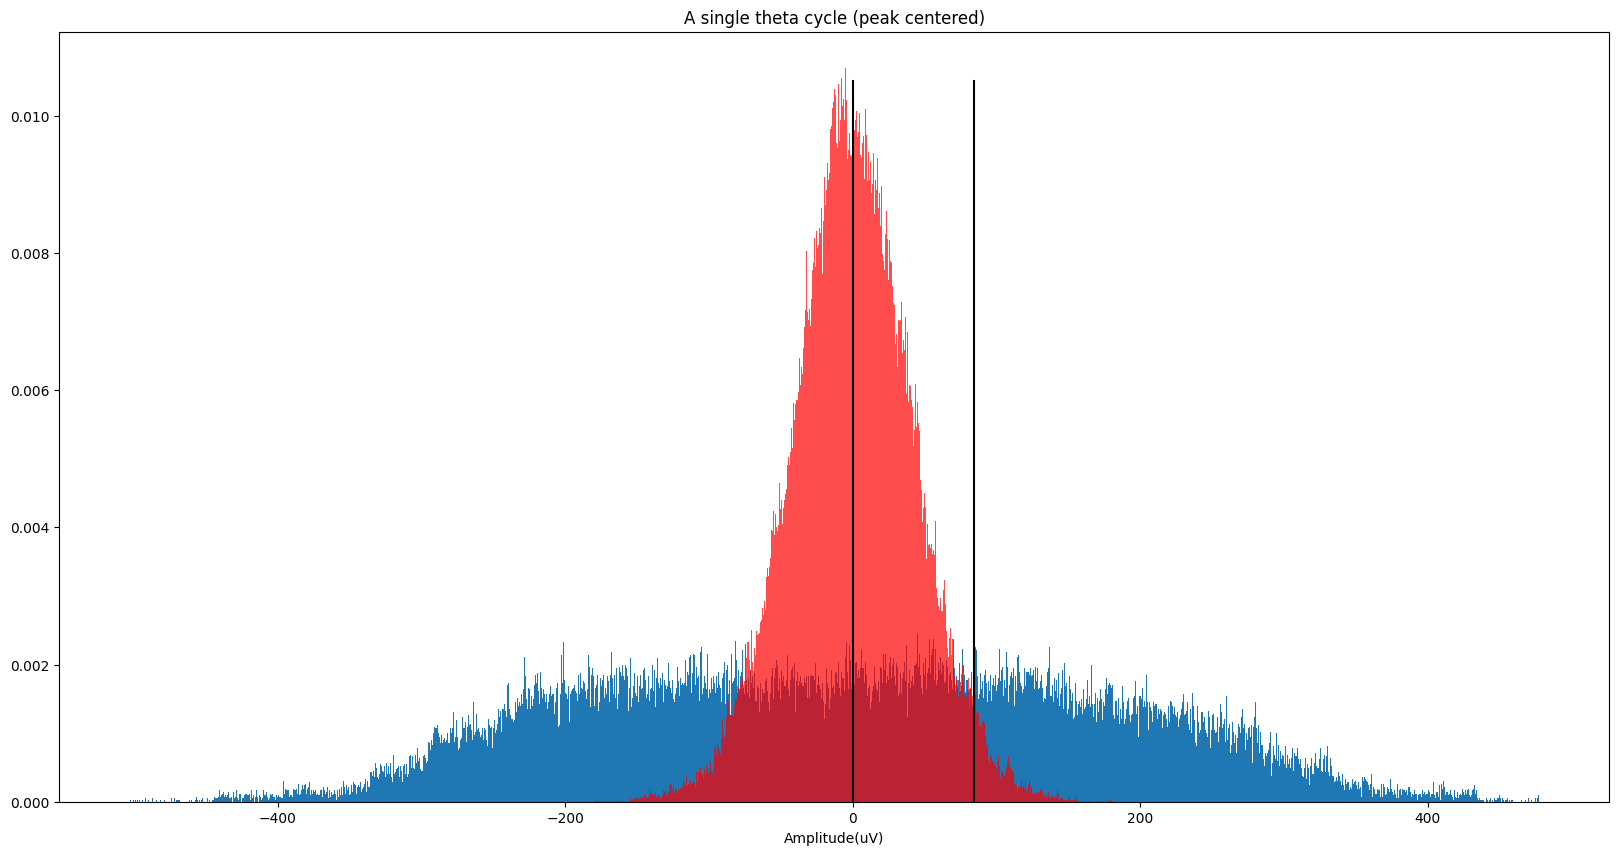

In [ ]:
min_peak_amp = 2 * sub_theta_sig.std()

plt.gcf().set_size_inches(20, 10)
plt.hist(theta_sig, bins=2500,density=True)
plt.hist(sub_theta_sig, bins=2500, alpha=0.7,density=True, color='red')
plt.plot(np.zeros(50), np.linspace(0,0.0105,50), color='black')
plt.plot(min_peak_amp*np.ones(50), np.linspace(0,0.0105,50), color='black')

plt.xlabel('Density')
plt.xlabel('Amplitude(uV)')
plt.title('Distribution of Amplitudes (Theta vs. Sub-theta)')
plt.show()

### Applying both the thresholds

We define the amplitude threshold filter mask and combine with the frequency threshold mask so we can omit cycles that do not satisfy both thresholds

In [ ]:
peak_mask = theta_peak_sig > min_peak_amp
extrema_mask = np.logical_and(np.squeeze(diff_mask), peak_mask)
theta_cycles=cycles[extrema_mask]
print(f'Number of theta cycles detected:{theta_cycles.shape[0]} out of {cycles.shape[0]} cycles')

Number of theta cycles detected:3124 out of 3602 cycles
